In [26]:
from time import time
from datetime import datetime
import numpy as np
def multiply(A,B):
    return [a*b for a,b in zip(A,B)]
def divide(A,B):
    return [a/b for a,b in zip(A,B)]

def minus(A,B):
    return [a-b for a,b in zip(A,B)]
def log(txt):
    f= open("log3.txt","a+")
    f.write('%s: %s \r\n'%(datetime.now().strftime('{%Y-%m-%d %H:%M:%S}'),txt))
    print(txt)
    f.close() 
def initial_log():
    f= open("log3.txt","w+")
    f.write('%s: starting.... \r\n'%(datetime.now().strftime('{%Y-%m-%d %H:%M:%S}')))
    f.close() 
import pickle
def savedf():
    with open('df.dat','wb') as f:
        pickle.dump((X_train, X_test, y_train, y_test),f)

def loaddf():
    global X_train, X_test, y_train, y_test
    with open('df.dat','rb') as f:
        X_train, X_test, y_train, y_test = pickle.load(f)
    print('train size:%i, test size:%i, var:%i'%(len(X_train),len(X_test),len(X_train[0])))

        
def save():
    with open('data3.dat','wb') as f:
        pickle.dump((i,mdl_1,mdl_2,mdl_3,RMSETest,RMSETrain,last_depth,last_rmse),f)
def load():
    global i,mdl_1,mdl_2,mdl_3,RMSETest,RMSETrain,last_depth,last_rmse
    with open('data3.dat','rb') as f:
        i,mdl_1,mdl_2,mdl_3,RMSETest,RMSETrain,last_depth,last_rmse = pickle.load(f)

def load1():
    global i,mdl_1,mdl_2,mdl_3,RMSETest,RMSETrain,last_depth,last_rmse
    with open('data1.dat','rb') as f:
        i,mdl_1,mdl_2,mdl_3,RMSETest,RMSETrain,last_depth,last_rmse = pickle.load(f)
import os
os.environ["PATH"] += os.pathsep +"C:\\Users\\User\\Downloads\\graphviz-2.38\\release\\bin"


In [27]:
from numpy import var

class Splitter:
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y

    def split(self,index,value):
        """ 
        Split X and Y based on the given variable index and value
  
        Parameters: 
            index (int): index of variable to splitted on
            value (float): the value of splitting varaible
          
        Returns: 
            right_x,left_x,rigth_y,left_y
        """
        right_x = [x for x in self.X if x[index]>=value]
        left_x = [x for x in self.X if x[index]<value]
        
        right_y = [self.Y[i] for i,x in enumerate(self.X) if x[index]>=value]
        left_y = [self.Y[i] for i,x in enumerate(self.X) if x[index]<value]
        return right_x,left_x,right_y,left_y
    
    def weighted_var(self,Y):
        if len(Y) ==0:
            return float('inf')
        return var(Y)/len(Y)
    
    def SE(self,Y):
        if len(Y) ==0: return float('inf')
        mean = sum(Y)/len(Y)
        SE = sum([(y-mean)**2 for y in Y])
        return SE
        
    
    def splitting_cost(self,right_x,left_x,right_y,left_y):
        """ 
        Compute cost of spliting.
        in the current version, we have used varaince based cost function
  
        Parameters: 
            right_x,left_x,rigth_y,left_y
          
        Returns: 
            float: the cost of computing
        """        
        return (self.SE(right_y)+self.SE(left_y))/(len(right_y)+len(left_y))
    
    def possibleValues(self,index):
        values = [x[index] for x in self.X]
        values.sort()
        max_values = 100
        if len(values)<max_values:
            return values
        
        return set([np.percentile(values,i*100//max_values) for i in range(max_values)])
    
    def test_splitting(self,index,value):
        right_x,left_x,right_y,left_y = self.split(index,value)
        return  self.splitting_cost(right_x,left_x,right_y,left_y),len(right_y),len(left_y)
    
    def find_best_splitting(self,min_leaf_treshold=30,min_split=70):
        """ 
        Find best splitting and return index and value of splitting variable respectively
       
        Returns: 
            int,float: the index and value of best possible splitting variables
        """ 
        
        best_splitting = (self.SE(self.Y)/len(self.Y))
        best_splitting_index = -1
        best_splitting_value = 0
        if len(self.Y)<min_split:
            return best_splitting_index,best_splitting_value            
        for index in range(len(self.X[0])):
            for value in self.possibleValues(index):
                splitting_cost,left_cnt,right_cnt = self.test_splitting(index,value)
#               print('splitting at %f: cost->%f'%(value,splitting_cost))
                if splitting_cost < best_splitting and left_cnt >= min_leaf_treshold and right_cnt >= min_leaf_treshold:
                    best_splitting = splitting_cost
                    best_splitting_index = index
                    best_splitting_value = value
        return best_splitting_index,best_splitting_value


In [31]:
id = 0
last_leaf_no = 1
def create_Tree():
    global last_leaf_no
    last_leaf_no = 1
    return Node(0)
class Node:
    isLeaf = True
    Left = None
    Right = None
    Value = None
    Depth = 0
    splitting_var_index = 0
    splitting_value = 0
    cnt = 0
    
    
    def __init__(self,depth):
        global id
        id+=1
        self.ID = id
        self.isLeaf = True
        self.Depth = depth
    def predict(self,X):
        return [self.predict_one(x) for x in X]
        
    def predict_one(self,X):
        if type(X) != list:
            raise TypeError("predict_one.X: expected list but recieved %s (%s)"%(X,type(X)))
        try:
            if self.isLeaf:
                self.cnt +=1
                return self.Value
            if X[self.splitting_var_index] >= self.splitting_value:
                return self.Right.predict_one(X)
            else:
                return self.Left.predict_one(X)
        except IndexError:
            print('index: %i'%self.splitting_var_index)
            raise
    
    
    def fit(self,X,Y,max_depth):
        global last_leaf_no

        #tree reached maximum depth
        if max_depth <= self.Depth:
            self.isLeaf = True
            self.leafID = last_leaf_no
            last_leaf_no+=1
            self.fit_leaf_value(Y)
            return 
        
        #continue splitting if more depth allowed
        splitter = Splitter(X,Y)

        best_splitting_index,best_splitting_value = splitter.find_best_splitting()
        if best_splitting_index == -1:
            #better to not split
            self.isLeaf = True
            self.leafID = last_leaf_no
            last_leaf_no+=1
            self.fit_leaf_value(Y)
        else:
            right_x,left_x,right_y,left_y = splitter.split(best_splitting_index,best_splitting_value)
            self.isLeaf = False
            self.splitting_var_index = best_splitting_index
            self.splitting_value = best_splitting_value
            self.Right = Node(self.Depth+1)
            self.Left = Node(self.Depth+1)
            self.Right.fit(right_x,right_y,max_depth)
            self.Left.fit(left_x,left_y,max_depth)
    def fit_leaf_value(self,Y):
        u = sum(Y)/len(Y)
        s = (1+0.1*abs(u))/(1+abs(u))
        self.Value = s*u
    
    def set_shrinkage(self, max_u):
        if self.isLeaf:
            s = (1+0.1*abs(self.Value))/(1+abs(max_u))
            self.Value *= s
        else:
            self.Right.set_shrinkage(max_u)
            self.Left.set_shrinkage(max_u)

        
    def tune(self,X,R,T):
        self.X = X
        self.Y = ['%f:%f'%(r,t) for r,t in zip(R,T)]
        if len(X) != len(R):
            raise TypeError("tune function: X and R should be with same size. recieved <%i>.<%i>"%(len(X),len(R)))
        if len(X) != len(T):
            raise TypeError("tune function: X and T should be with same size. recieved <%i>.<%i>"%(len(X),len(T)))
            
        if self.isLeaf:
            if sum(multiply(T,T)) == 0:
                self.value = 1
            else:
                self.Value = sum(multiply(R,T))/sum(multiply(T,T))
            return
        
        splitter = Splitter(X,R)
        right_x,left_X,right_R,left_R = splitter.split(self.splitting_var_index,self.splitting_value)
        splitter = Splitter(X,T)
        right_x,left_X,right_T,left_T = splitter.split(self.splitting_var_index,self.splitting_value)
        self.Right.tune(right_x,right_R,right_T)
        self.Left.tune(left_X,left_R,left_T)
        
    def draw_tree(self):
        from graphviz import Source
        from io import BytesIO
        from matplotlib import pyplot as plt
        from matplotlib import image
        g = Source('digraph {\n\tgraph [rankdir=UT]\n'+self.print_tree()+'}')
        g.render('round-table.gv', view=True)
        #return img
        
    def get_leafcounts(self):
        if self.isLeaf:
            return 1
        return self.Left.get_leafcounts()+self.Right.get_leafcounts()
    
    def print_tree(self,prefix=''):
        '\t0 [label="f0<8.40779079e-45] yes=1,no=2,missing=1\n\t1:[f0<2.80259693e-45] yes=3,no=4,missing=3\n\t\t3:leaf=7.46349096\n\t\t4:leaf=-0.278686523\n\t2:[f0<8.40779079e-45] yes=5,no=6,missing=5\n\t\t5:leaf=-0\n\t\t6:leaf=-0.188493282\n'
        if not self.isLeaf:
            ret = '\t%i [label="f%i>=%f"]\n\t%i -> %i [label="yes" color="#0000FF"]\n\t %i -> %i [label=no color="#FF0000"]\n'%(
                self.ID,self.splitting_var_index,self.splitting_value,self.ID,self.Right.ID,self.ID,self.Left.ID)
            ret += self.Right.print_tree(prefix+'\t')
            ret += self.Left.print_tree(prefix+'\t')
            return ret
        else:
            return '\t%i [label="leaf=%f\nCount=%i"]\n'%(self.ID,self.Value,self.cnt)
    def get_leaf_values(self):
        if self.isLeaf:
            return [self.Value]
        return self.Right.get_leaf_values()+self.Left.get_leaf_values()
    
'''digraph {
	graph [rankdir=UT]
	0 [label="f0<8.40779079e-45"]
	0 -> 1 [label="yes, missing" color="#0000FF"]
	0 -> 2 [label=no color="#FF0000"]
	1 [label="f0<2.80259693e-45"]
	1 -> 3 [label="yes, missing" color="#0000FF"]
	1 -> 4 [label=no color="#FF0000"]
	3 [label="leaf=7.46349096"]
	4 [label="leaf=-0.278686523"]
	2 [label="f0<8.40779079e-45"]
	2 -> 5 [label="yes, missing" color="#0000FF"]
	2 -> 6 [label=no color="#FF0000"]
	5 [label="leaf=-0"]
	6 [label="leaf=-0.188493282"]
}'''       
        

'digraph {\n\tgraph [rankdir=UT]\n\t0 [label="f0<8.40779079e-45"]\n\t0 -> 1 [label="yes, missing" color="#0000FF"]\n\t0 -> 2 [label=no color="#FF0000"]\n\t1 [label="f0<2.80259693e-45"]\n\t1 -> 3 [label="yes, missing" color="#0000FF"]\n\t1 -> 4 [label=no color="#FF0000"]\n\t3 [label="leaf=7.46349096"]\n\t4 [label="leaf=-0.278686523"]\n\t2 [label="f0<8.40779079e-45"]\n\t2 -> 5 [label="yes, missing" color="#0000FF"]\n\t2 -> 6 [label=no color="#FF0000"]\n\t5 [label="leaf=-0"]\n\t6 [label="leaf=-0.188493282"]\n}'

In [32]:
    from copy import deepcopy
    from sklearn.metrics import mean_squared_error
    from math import sqrt


    class FractBoosting:

        def __init__(self):
            self.learning_rate = 1
            self.trees = []

        def predict(self,X):
            Y = []
            for x in X:
                predictions = [S.predict([x])[0]*T.predict([x])[0] for S,T in self.trees]
                predict = predictions[0] + self.learning_rate*sum(predictions[1:])
                Y.append(predict)

            return Y

        def fit(self,X,Y,max_depth,max_trees):
            """ 
            Fit the boosting trees on the given data

            Parameters: 
                X (list of list): the input X
                Y (list): input Y
                max_depth (int): maximum depth of trees
                max_trees (int): the number of trees
            """ 

            lastRMSE = self.rmse(X,Y)
            improvment = []
            for i in range(1,max_trees):
                t0 = time()
                depth = int(1+max_depth*sqrt(i/max_trees))
                log('starting itteration %i with depth %i'%(i,depth))
    #            print('itteration %i, begining, mean loss: %f, tree depth: %i'%(i,self.rmse(X,Y),depth))
                self.fit_one_step(X,Y,depth)

                current_rmse = self.rmse(X,Y)
                RMSEDif = lastRMSE - current_rmse
                lastRMSE = current_rmse
                cost = T.get_leafcounts()
                imp = cost/RMSEDif
                improvment.append(imp)
                log('itteration %i done in %0.3fs, RMSE: %f, Cost/improvement: %f'%(i,time() - t0,current_rmse,imp))
            return improvment
        def create_root_tree(self,Y):
            root_s = create_Tree()
            root_s.Value = 1
            root_t = create_Tree()
            root_t.fit_leaf_value(Y)
            self.trees = [(root_s,root_t)]

        def fit_one_step(self,X,Y,depth,back_pro):
            Y_r = self.get_residual(X,Y)
            T = create_Tree()
            T.fit(X,Y_r,depth)
#            max_u = max(T.get_leaf_values())
#            T.set_shrinkage(max_u)
            Y_t = T.predict(X)
            S = deepcopy(self.trees[-1][1])
            S.tune(X,Y_r,Y_t)
            self.trees.append((S,T))
        def get_residual(self,X,Y):
            h = self.predict(X)
            Y_r = minus(Y , h)
            return Y_r
        def print_trees(self):
            for i,(s,t) in enumerate(self.trees):
                print('%ith fractal tree\n'%i)
                print('-----------------\n')
                print('S:\n')
                s.print_tree()
                print('-----------------\n')
                print('T:\n')
                t.print_tree()
                print('\n-----------------\n')

        def rmse(self,X,Y):
            h = self.predict(X)
    #        R = minus(Y , h)
    #        print('Residual:',R)
            return sqrt(mean_squared_error(h, Y))


In [33]:
from numpy import std
import xgboost as xgb
from threading import Thread
from xgboost import plot_tree
from sklearn.metrics import mean_squared_error
max_depth=5

loaddf()
#initial_log()
mdl_1 = FractBoosting()
mdl_2 = FractBoosting()
mdl_3 = FractBoosting()
mdl_1.create_root_tree(y_train)
mdl_2.create_root_tree(y_train)
mdl_3.create_root_tree(y_train)
last_rmse = mdl_3.rmse(X_train,y_train)
last_depth = 1

m = sum(y_train)/len(y_train)
y_train_xgb = [y-m for y in y_train]

RMSETest = [[],[],[],[],[],[]]
RMSETrain =  [[],[],[],[],[],[]]
i=0
try:
    load()
except Exception as e:
    print(e)
    initial_log()
if len(RMSETest) < 6:
    RMSETest.append([])
    RMSETest.append([])
    RMSETrain.append([])
    RMSETrain.append([])
try:
    while i<200:
        processes = []




        ################Fixed depth
        mdl_1.fit_one_step(X_train,y_train,max_depth)
        RMSETrain[0].append( mdl_1.rmse(X_train,y_train))
        RMSETest[0].append( mdl_1.rmse(X_test,y_test))    
        print('Fixed depth')


        
        ###############Linear depth
        depth = min(5,int(1+max_depth*(i/50)))
        mdl_2.fit_one_step(X_train,y_train,depth)    
        RMSETrain[1].append( mdl_2.rmse(X_train,y_train))
        RMSETest[1].append( mdl_2.rmse(X_test,y_test))    
        print('Linear depth')


        ###############dynamic depth
        mdl_3.fit_one_step(X_train,y_train,last_depth)
        mdl3_rmse = mdl_3.rmse(X_test,y_test)
        RMSETrain[2].append( mdl_3.rmse(X_train,y_train))
        RMSETest[2].append( mdl_3.rmse(X_test,y_test))
        print('dynamic depth')
        


        ##################XGBoost
        xg_reg = xgb.XGBRegressor( learning_rate = 0.1,
                        max_depth = 5,  n_estimators = i)
        xg_reg.fit(X_train,y_train_xgb)    
        preds = xg_reg.predict(X_train)
        RMSETrain[3].append(np.sqrt(mean_squared_error(y_train, [p+m for p in preds])))
        preds = xg_reg.predict(X_test)
        RMSETest[3].append(np.sqrt(mean_squared_error(y_test, [p+m for p in preds])))
        print('XGB')
        
        xg_reg = xgb.XGBRegressor( learning_rate = 0.1,
                        max_depth = 1,  n_estimators = i)
        xg_reg.fit(X_train,y_train_xgb)    
        preds = xg_reg.predict(X_train)
        RMSETrain[4].append(np.sqrt(mean_squared_error(y_train, [p+m for p in preds])))
        preds = xg_reg.predict(X_test)
        RMSETest[4].append(np.sqrt(mean_squared_error(y_test, [p+m for p in preds])))
        
                
        xg_reg = xgb.XGBRegressor( learning_rate = 0.1,
                        max_depth = 2,  n_estimators = i)
        xg_reg.fit(X_train,y_train_xgb)    
        preds = xg_reg.predict(X_train)
        RMSETrain[5].append(np.sqrt(mean_squared_error(y_train, [p+m for p in preds])))
        preds = xg_reg.predict(X_test)
        RMSETest[5].append(np.sqrt(mean_squared_error(y_test, [p+m for p in preds])))
        
        print('XGB')
        i+=1
        
        save()
                           
        log('\r\n-----------------------------------------------\r\n'+
            'ittr %i \tTrain\t\tTest\t\tDiff\t\tRVar\tSVar\tTVar\r\n'%i+
            'FGB[%i]:\t%.2f\t\t%.2f\t\t%.2f\t\t%.1f\t%.1f\t\t%.1f\r\n'%(max_depth,RMSETrain[0][-1],RMSETest[0][-1],RMSETest[0][-1]-RMSETrain[0][-1],std(mdl_1.get_residual(X_train,y_train)),std(mdl_1.trees[-1][0].get_leaf_values()),std(mdl_1.trees[-1][1].get_leaf_values()))+
            'FGB[%i]:\t%.2f\t\t%.2f\t\t%.2f\t\t%.1f\t%.1f\t\t%.1f\r\n'%(depth,RMSETrain[1][-1],RMSETest[1][-1],RMSETest[1][-1]-RMSETrain[1][-1],std(mdl_2.get_residual(X_train,y_train)),std(mdl_2.trees[-1][0].get_leaf_values()),std(mdl_2.trees[-1][1].get_leaf_values()))+
            'FGB[%i]:\t%.2f\t\t%.2f\t\t%.2f\t\t%.1f\t%.1f\t\t%.1f\r\n'%(last_depth,RMSETrain[2][-1],RMSETest[2][-1],RMSETest[2][-1]-RMSETrain[2][-1],std(mdl_3.get_residual(X_train,y_train)),std(mdl_3.trees[-1][0].get_leaf_values()),std(mdl_3.trees[-1][1].get_leaf_values()))+
            'XGB[%i]:\t%.2f\t\t%.2f\t\t%.2f \r\n'%(1,RMSETrain[5][-1],RMSETest[5][-1],RMSETest[5][-1]-RMSETrain[5][-1])+
            'XGB[%i]:\t%.2f\t\t%.2f\t\t%.2f \r\n'%(2,RMSETrain[4][-1],RMSETest[4][-1],RMSETest[4][-1]-RMSETrain[4][-1])+
            'XGB[%i]:\t%.2f\t\t%.2f\t\t%.2f \r\n'%(max_depth,RMSETrain[3][-1],RMSETest[3][-1],RMSETest[3][-1]-RMSETrain[3][-1]))

        if (last_rmse/mdl3_rmse)<1.005 and last_depth < max_depth:
            last_depth +=1
        last_rmse = mdl3_rmse

except Exception as e:
    log(e)
    raise


train size:36000, test size:36000, var:3
[Errno 2] No such file or directory: 'data3.dat'
Fixed depth
Linear depth
dynamic depth
[19:15:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[19:15:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:15:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 1 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	6229.70		6300.63		70.94		6229.7	0.0		387.6
FGB[1]:	6897.47		6937.02		39.55		6897.5	0.0		162.9
FGB[1]:	6897.47		6937.02		39.55		6897.5	0.0		162.9
XGB[1]:	7085.34		7132.14		46.80 
XGB[2]:	7085.34		7132.14		46.80 
XGB[5]:	7085.34		7132.14		46.80 

Fixed depth
Linear depth
dy

XGB
[19:26:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 10 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	5901.01		6103.29		202.28		5901.0	68.0		177.5
FGB[1]:	6571.18		6613.34		42.16		6571.0	20.0		34.9
FGB[3]:	6376.26		6427.76		51.50		6376.2	3.4		102.2
XGB[1]:	6755.07		6801.11		46.04 
XGB[2]:	6887.66		6934.77		47.11 
XGB[5]:	6350.63		6417.47		66.84 

Fixed depth
Linear depth
dynamic depth
[19:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[19:27:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:l

XGB

-----------------------------------------------
ittr 19 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	5756.75		6116.20		359.44		5756.8	26.1		171.2
FGB[2]:	6426.43		6460.65		34.22		6426.3	8.6		50.7
FGB[5]:	5998.15		6148.60		150.46		5998.1	13.5		212.5
XGB[1]:	6629.72		6674.66		44.94 
XGB[2]:	6806.87		6854.83		47.96 
XGB[5]:	6114.54		6199.31		84.77 

Fixed depth
Linear depth
dynamic depth
[19:45:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[19:45:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 20 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	5742.28		

Fixed depth
Linear depth
dynamic depth
[20:07:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[20:07:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 29 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	5629.22		6116.05		486.83		5629.2	114.4		147.6
FGB[3]:	6186.24		6260.46		74.22		6186.2	5.4		78.7
FGB[5]:	5801.74		6108.02		306.28		5801.7	27.7		173.5
XGB[1]:	6552.75		6596.59		43.85 
XGB[2]:	6760.66		6808.36		47.70 
XGB[5]:	6017.36		6116.58		99.23 

Fixed depth
Linear depth
dynamic depth
[20:10:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/o

XGB
[20:34:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 38 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	5533.28		6141.08		607.80		5533.3	40.8		136.3
FGB[4]:	6005.44		6122.99		117.55		6005.4	54.1		147.7
FGB[5]:	5688.21		6092.60		404.39		5688.2	25.1		135.7
XGB[1]:	6509.04		6554.29		45.25 
XGB[2]:	6739.06		6787.02		47.96 
XGB[5]:	5974.89		6085.84		110.95 

Fixed depth
Linear depth
dynamic depth
[20:37:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[20:37:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: 

XGB

-----------------------------------------------
ittr 47 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	5448.34		6182.13		733.78		5448.3	53.2		130.5
FGB[5]:	5843.21		6099.25		256.04		5843.2	40.8		137.8
FGB[5]:	5583.40		6116.43		533.03		5583.4	31.6		164.5
XGB[1]:	6478.55		6523.10		44.55 
XGB[2]:	6722.91		6770.27		47.37 
XGB[5]:	5950.18		6071.11		120.93 

Fixed depth
Linear depth
dynamic depth
[21:10:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[21:10:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:10:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 48 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	5438.

Fixed depth
Linear depth
dynamic depth
[21:47:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[21:47:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:47:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 57 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	5358.74		6210.27		851.53		5358.7	62.3		153.3
FGB[5]:	5721.54		6126.34		404.80		5721.5	294.5		197.5
FGB[5]:	5485.27		6123.80		638.53		5485.3	73.1		162.2
XGB[1]:	6461.65		6507.16		45.51 
XGB[2]:	6708.15		6755.82		47.67 
XGB[5]:	5930.86		6060.34		129.48 

Fixed depth
Linear depth
dynamic depth
[21:52:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/s

XGB
[22:30:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:30:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 66 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	5265.11		6224.45		959.34		5265.1	16.9		141.3
FGB[5]:	5613.78		6132.32		518.53		5613.8	60.8		179.6
FGB[5]:	5394.67		6152.33		757.65		5394.7	35.2		138.9
XGB[1]:	6442.97		6489.69		46.72 
XGB[2]:	6696.79		6745.75		48.96 
XGB[5]:	5908.94		6047.84		138.90 

Fixed depth
Linear depth
dynamic depth
[22:35:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[22:35:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: 

XGB

-----------------------------------------------
ittr 75 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	5182.60		6233.34		1050.74		5182.6	110.6		122.1
FGB[5]:	5506.67		6143.59		636.92		5506.7	122.4		143.0
FGB[5]:	5313.40		6157.96		844.56		5313.4	25.8		120.8
XGB[1]:	6427.52		6476.16		48.65 
XGB[2]:	6687.02		6735.68		48.66 
XGB[5]:	5887.50		6037.58		150.08 

Fixed depth
Linear depth
dynamic depth
[23:23:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[23:23:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:23:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 76 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	51

Fixed depth
Linear depth
dynamic depth
[00:17:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[00:17:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 85 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	5101.53		6255.62		1154.09		5101.5	55.6		126.1
FGB[5]:	5393.23		6168.98		775.75		5393.2	244.5		136.0
FGB[5]:	5228.45		6192.03		963.58		5228.5	27.1		121.1
XGB[1]:	6414.22		6464.65		50.44 
XGB[2]:	6677.90		6726.64		48.75 
XGB[5]:	5856.00		6022.10		166.10 

Fixed depth
Linear depth
dynamic depth
[00:23:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/

XGB
[01:19:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:19:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 94 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	5043.10		6269.98		1226.88		5043.1	70.7		80.4
FGB[5]:	5311.58		6184.43		872.85		5311.6	32.5		110.1
FGB[5]:	5151.82		6198.06		1046.24		5151.8	58.9		105.3
XGB[1]:	6403.66		6455.21		51.55 
XGB[2]:	6670.92		6720.00		49.07 
XGB[5]:	5832.19		6009.13		176.95 

Fixed depth
Linear depth
dynamic depth
[01:26:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[01:26:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152:

[02:29:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 103 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	4983.19		6294.24		1311.05		4983.2	191.1		113.1
FGB[5]:	5219.29		6319.08		1099.79		5219.3	112.9		131.7
FGB[5]:	5093.80		6207.33		1113.54		5093.8	27.7		111.7
XGB[1]:	6392.56		6444.03		51.47 
XGB[2]:	6664.82		6714.31		49.49 
XGB[5]:	5810.81		6000.49		189.68 

Fixed depth
Linear depth
dynamic depth
[02:37:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[02:37:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:37:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152

XGB

-----------------------------------------------
ittr 112 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	4922.49		6299.20		1376.71		4922.5	48.2		111.7
FGB[5]:	5144.00		6342.70		1198.69		5144.0	26.3		148.5
FGB[5]:	5027.87		6219.22		1191.35		5027.9	63.4		130.4
XGB[1]:	6380.30		6431.98		51.68 
XGB[2]:	6659.56		6709.11		49.56 
XGB[5]:	5791.46		5992.39		200.93 

Fixed depth
Linear depth
dynamic depth
[03:55:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[03:55:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:55:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 113 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	

Fixed depth
Linear depth
dynamic depth
[05:15:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[05:15:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:15:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 122 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	4858.27		6314.91		1456.65		4858.3	103.2		93.6
FGB[5]:	5078.75		6367.67		1288.92		5078.7	52.3		94.6
FGB[5]:	4958.50		6234.31		1275.81		4958.5	238.4		108.7
XGB[1]:	6370.96		6423.22		52.26 
XGB[2]:	6654.39		6704.02		49.63 
XGB[5]:	5775.50		5986.05		210.55 

Fixed depth
Linear depth
dynamic depth
[05:24:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.9

XGB
[06:45:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:45:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 131 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	4800.28		6339.32		1539.05		4800.3	30.9		112.7
FGB[5]:	5020.52		6374.90		1354.38		5020.5	28.6		106.1
FGB[5]:	4898.56		6248.29		1349.73		4898.6	60.4		69.3
XGB[1]:	6363.89		6416.86		52.98 
XGB[2]:	6650.28		6699.70		49.42 
XGB[5]:	5758.07		5979.69		221.62 

Fixed depth
Linear depth
dynamic depth
[06:56:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[06:56:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:15

[08:21:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 140 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	4743.19		6348.54		1605.35		4743.2	39.9		127.8
FGB[5]:	4954.99		6391.88		1436.88		4955.0	60.6		84.1
FGB[5]:	4834.48		6259.56		1425.08		4834.5	41.8		93.0
XGB[1]:	6356.41		6409.47		53.06 
XGB[2]:	6646.55		6695.79		49.25 
XGB[5]:	5736.30		5970.99		234.69 

Fixed depth
Linear depth
dynamic depth
[08:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[08:31:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:31:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: re

XGB

-----------------------------------------------
ittr 149 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	4686.50		6367.25		1680.75		4686.5	51.9		89.6
FGB[5]:	4895.33		6416.21		1520.88		4895.3	19.8		110.9
FGB[5]:	4778.33		6274.29		1495.96		4778.3	148.5		122.7
XGB[1]:	6348.82		6401.46		52.64 
XGB[2]:	6643.15		6692.18		49.03 
XGB[5]:	5720.29		5964.81		244.52 

Fixed depth
Linear depth
dynamic depth
[10:01:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[10:01:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:01:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 150 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	

Fixed depth
Linear depth
dynamic depth
[11:40:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[11:41:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:41:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 159 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	4629.15		6398.46		1769.31		4629.1	58.3		96.3
FGB[5]:	4833.13		6434.60		1601.48		4833.1	44.0		118.0
FGB[5]:	4724.34		6277.47		1553.13		4724.3	48.3		69.7
XGB[1]:	6336.27		6390.01		53.74 
XGB[2]:	6639.68		6688.65		48.97 
XGB[5]:	5701.74		5957.55		255.81 

Fixed depth
Linear depth
dynamic depth
[11:52:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/

XGB
[13:39:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 168 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	4572.98		6408.20		1835.22		4573.0	94.2		80.2
FGB[5]:	4775.89		6451.43		1675.54		4775.9	52.5		105.0
FGB[5]:	4668.75		6282.31		1613.56		4668.7	43.0		100.6
XGB[1]:	6330.29		6385.82		55.53 
XGB[2]:	6636.84		6685.72		48.88 
XGB[5]:	5679.85		5949.48		269.63 

Fixed depth
Linear depth
dynamic depth
[13:52:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[13:53:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:15

[15:48:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 177 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	4519.80		6423.51		1903.71		4519.8	111.2		95.1
FGB[5]:	4719.21		6474.23		1755.02		4719.2	64.5		107.5
FGB[5]:	4621.56		6299.69		1678.13		4621.6	26.9		72.0
XGB[1]:	6318.75		6375.49		56.74 
XGB[2]:	6634.23		6683.39		49.16 
XGB[5]:	5659.43		5941.00		281.57 

Fixed depth
Linear depth
dynamic depth
[16:03:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[16:03:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:03:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: r

XGB

-----------------------------------------------
ittr 186 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	4467.01		6434.46		1967.44		4467.0	60.1		121.7
FGB[5]:	4662.50		6477.77		1815.27		4662.5	53.5		106.0
FGB[5]:	4580.31		6326.70		1746.39		4580.3	81.0		117.2
XGB[1]:	6312.06		6369.98		57.91 
XGB[2]:	6631.76		6680.53		48.77 
XGB[5]:	5646.00		5937.39		291.40 

Fixed depth
Linear depth
dynamic depth
[18:22:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[18:22:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 187 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	

Fixed depth
Linear depth
dynamic depth
[20:40:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB
[20:40:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:40:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB

-----------------------------------------------
ittr 196 	Train		Test		Diff		RVar	SVar	TVar
FGB[5]:	4419.34		6445.49		2026.15		4419.3	82.2		75.6
FGB[5]:	4601.60		6477.42		1875.82		4601.6	58.7		83.5
FGB[5]:	4533.77		6334.49		1800.72		4533.8	46.9		93.0
XGB[1]:	6302.84		6360.72		57.87 
XGB[2]:	6629.21		6678.40		49.19 
XGB[5]:	5624.17		5929.87		305.70 

Fixed depth
Linear depth
dynamic depth
[20:58:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/s

In [15]:
import pandas as pd

from sklearn.model_selection import train_test_split
df_train = pd.read_csv('Sydney_Data.csv',header=None)
df_train.head() 
X = df_train.loc[:,0:41].values.tolist()
Y = df_train[42].values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)
print('train size:%i, test size:%i, var:%i'%(len(X_train),len(X_test),len(X_train[0])))
savedf()

train size:43200, test size:28800, var:42


In [25]:
Y

NameError: name 'Y' is not defined

In [5]:
load1()
loaddf()

In [23]:
def sumcnt(Node):
    if Node.isLeaf:
        return Node.cnt
    return sumcnt(Node.Left)+sumcnt(Node.Right)
sumcnt(node)

36000

In [37]:
node = mdl_1.trees[57][1]
node.predict(X_test)
node.draw_tree()

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(500, 500))
removeXY(mdl.trees[58][2])
mdl.trees[85][0].draw_tree(ax=ax)
plt.show()

In [38]:
import xgboost as xgb
from xgboost import plot_tree
from sklearn.metrics import mean_squared_error

xg_reg = xgb.XGBRegressor( learning_rate = 0.1,
                max_depth = 5,  n_estimators = 8)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
print('RMSE: %f'%np.sqrt(mean_squared_error(y_test, preds)))
for a,b in  zip(y_test[:10],preds[:10]):
    print('%0.2f\t%0.2f\t%0.2f'%(a,b,abs(a-b)))

[09:07:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 40800.016106
98135.69	52899.11	45236.58
103259.84	53311.32	49948.52
96434.01	52821.76	43612.25
80954.96	50414.98	30539.98
103742.74	53180.94	50561.80
97814.02	53180.94	44633.08
101013.30	55209.25	45804.05
90743.07	53180.94	37562.13
96397.29	54454.34	41942.95
93122.03	52760.19	40361.84


In [17]:
        xg_reg = xgb.XGBRegressor( learning_rate = 0.1,
                        max_depth = 1,  n_estimators = i)
        xg_reg.fit(X_train,y_train_xgb)    
        preds = xg_reg.predict(X_train)
        print(np.sqrt(mean_squared_error(y_train, [p+m for p in preds])))
        preds = xg_reg.predict(X_test)
        print(np.sqrt(mean_squared_error(y_test, [p+m for p in preds])))
        
                
        xg_reg = xgb.XGBRegressor( learning_rate = 0.1,
                        max_depth = 2,  n_estimators = i)
        xg_reg.fit(X_train,y_train_xgb)    
        preds = xg_reg.predict(X_train)
        print(np.sqrt(mean_squared_error(y_train, [p+m for p in preds])))
        preds = xg_reg.predict(X_test)
        print(np.sqrt(mean_squared_error(y_test, [p+m for p in preds])))

[03:49:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5515.560315843102
5497.0595696182345
[03:50:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4666.288729677609
4655.809304430131


In [18]:
mdl_1.trees[58][1].print_tree()

'\t8239 [label="f0>=0.937574"]\n\t8239 -> 8240 [label="yes" color="#0000FF"]\n\t 8239 -> 8241 [label=no color="#FF0000"]\n\t8240 [label="f1>=566.000000"]\n\t8240 -> 8242 [label="yes" color="#0000FF"]\n\t 8240 -> 8243 [label=no color="#FF0000"]\n\t8242 [label="f0>=261.687736"]\n\t8242 -> 8244 [label="yes" color="#0000FF"]\n\t 8242 -> 8245 [label=no color="#FF0000"]\n\t8244 [label="f0>=295.245304"]\n\t8244 -> 8246 [label="yes" color="#0000FF"]\n\t 8244 -> 8247 [label=no color="#FF0000"]\n\t8246 [label="f0>=300.930229"]\n\t8246 -> 8248 [label="yes" color="#0000FF"]\n\t 8246 -> 8249 [label=no color="#FF0000"]\n\t8248 [label="leaf=-9.042450\nleafNo=1"]\n\t8249 [label="leaf=3313.563438\nleafNo=2"]\n\t8247 [label="f2>=12.680816"]\n\t8247 -> 8250 [label="yes" color="#0000FF"]\n\t 8247 -> 8251 [label=no color="#FF0000"]\n\t8250 [label="leaf=-967.480983\nleafNo=3"]\n\t8251 [label="leaf=-7502.263990\nleafNo=4"]\n\t8245 [label="f0>=195.196900"]\n\t8245 -> 8252 [label="yes" color="#0000FF"]\n\t 824

In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xg_reg = xgb.XGBRegressor( learning_rate = 0.1,
                max_depth = 5,  n_estimators = 100
                         )
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
print('RMSE: %f'%np.sqrt(mean_squared_error(y_test, preds)))
for a,b in  zip(y_test[:10],preds[:10]):
    print('%0.2f\t%0.2f\t%0.2f'%(a,b,abs(a-b)))

[12:34:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 3238.733679
95716.83	96374.12	657.30
93197.34	90694.52	2502.82
93012.06	89242.32	3769.74
96252.08	95166.41	1085.68
100017.88	100426.52	408.64
89233.71	96014.59	6780.88
88295.06	91161.50	2866.44
97701.73	97152.05	549.68
102094.01	99968.95	2125.05
86614.54	84039.80	2574.74


In [44]:
import random
X = [[random.randint(1,10)] for i in range(20)]
Y = random.sample(range(1,100),20)
X=[[14],[10],[2],[62],[54],[93],[51],[61],[85],[49]]
Y=[34,22,96,72,79,25,83,48,54,5]
print(X)
print(Y)
mdl = FractBoosting(1)
mdl.fit(X,Y,1,3)


[[14], [10], [2], [62], [54], [93], [51], [61], [85], [49]]
[34, 22, 96, 72, 79, 25, 83, 48, 54, 5]
itteration 1, begining, mean loss: 28.648909
splitting at 2.000000: cost->820.760000
splitting at 10.000000: cost->603.688889
splitting at 14.000000: cost->807.800000
splitting at 49.000000: cost->820.209524
splitting at 51.000000: cost->715.758333
splitting at 54.000000: cost->806.320000
splitting at 61.000000: cost->817.958333
splitting at 62.000000: cost->819.838095
splitting at 85.000000: cost->782.937500
splitting at 93.000000: cost->740.955556
itteration 1, middle, mean loss: 24.570081
itteration 1, end, mean loss: 24.570081
itteration 2, begining, mean loss: 24.570081
splitting at 2.000000: cost->603.688889
splitting at 10.000000: cost->603.688889
splitting at 14.000000: cost->564.972840
splitting at 49.000000: cost->535.728865
splitting at 51.000000: cost->339.239815
splitting at 54.000000: cost->527.805432
splitting at 61.000000: cost->598.231584
splitting at 62.000000: cost->59

In [ ]:
def removeXY(node):
    if node == None:
        return
    node.X = node.Y = ''
    removeXY(node.Left)
    removeXY(node.Right)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(500, 500))
removeXY(mdl.trees[85][0])
mdl.trees[85][0].draw_tree(ax=ax)
plt.show()



[09:10:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


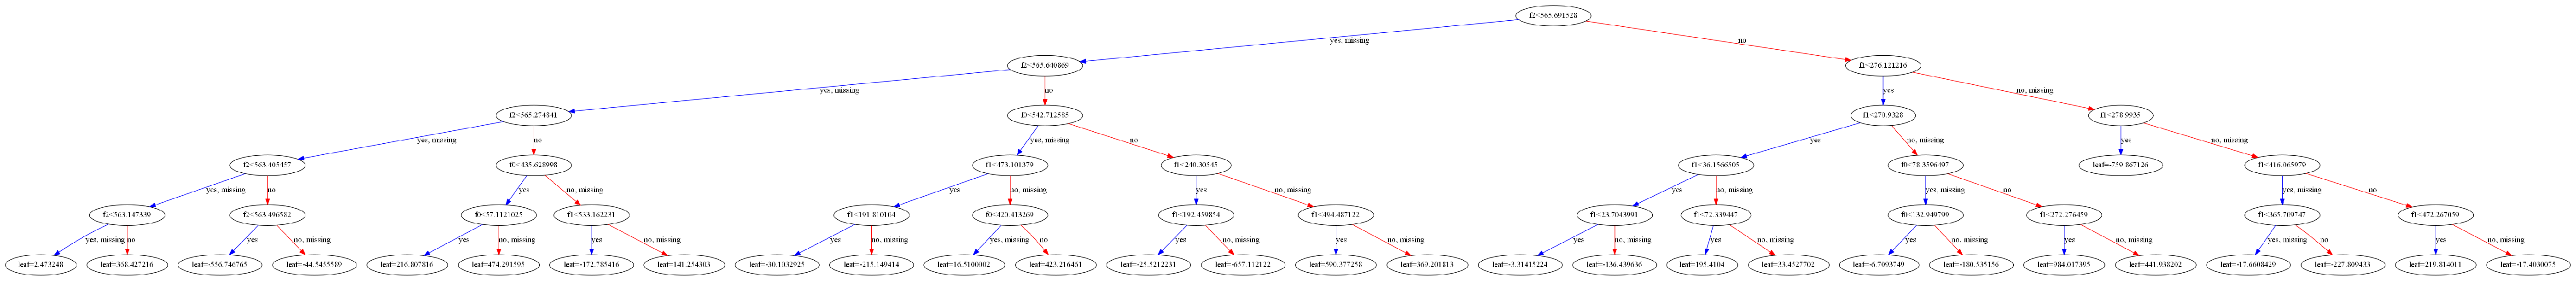

In [7]:
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#print(os.environ["PATH"])
xg_reg = xgb.XGBRegressor( learning_rate = .1,
                max_depth = 5,  n_estimators = 80,)
xg_reg.fit(X_train,y_train)
fig, ax = plt.subplots(figsize=(100, 100))
plot_tree(xg_reg,ax=ax,num_trees=79)
plt.show()

In [169]:
import pandas as pd
import numpy as np
df_train = pd.read_csv('train.csv')
X = df_train[['OverallQual', 'GrLivArea', 'GarageCars']].values.tolist()
Y = df_train['SalePrice'].values.tolist()

In [31]:
import random
X = [[random.randint(1,100)] for i in range(4)]
Y = random.sample(range(1,100),4)
print(X)
print(Y)
mdl = FractBoosting(1)
mdl.fit(X,Y,1,4)
mdl.print_trees()

[[70], [1], [30], [100]]
[4, 7, 48, 13]
itteration 1, mean loss: 16.436747
itteration 2, mean loss: 6.246480
itteration 3, mean loss: 3.415585
0th fractal tree

-----------------

S:

---1.000000
-----------------

T:

---18.000000

-----------------

1th fractal tree

-----------------

S:

---1.000000
-----------------

T:

---X[0] >= 30.000000 
------3.666667
-------11.000000

-----------------

2th fractal tree

-----------------

S:

---X[0] >= 30.000000 
------1.333333
-------0.000000
-----------------

T:

---X[0] >= 70.000000 
-------13.166667
------13.166667

-----------------

3th fractal tree

-----------------

S:

---X[0] >= 70.000000 
------0.900791
------1.519231
-----------------

T:

---X[0] >= 100.000000 
------8.888889
------2.888889

-----------------

